In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

<h2>1. Importing and Checking Data<h2/>

In [2]:
sun_df = pd.read_csv('./Sunspots.csv')
sun_df=pd.DataFrame(sun_df)
sun_df.shape

(3252, 3)

In [3]:
#rename data columns
sun_df=sun_df.rename(columns= {"Unnamed: 0" : "Id","Date": "Date","Monthly Mean Total Sunspot Number": "Sunspots"})
sun_df.info()
sun_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3252 non-null   int64  
 1   Date      3252 non-null   object 
 2   Sunspots  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB


,Id,Date,Sunspots
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
date = sun_df['Date'].values
date

array(['1749-01-31', '1749-02-28', '1749-03-31', ..., '2019-10-31',
       '2019-11-30', '2019-12-31'], dtype=object)

In [5]:
sunspots = sun_df['Sunspots'].values
sunspots

array([ 96.7, 104.3, 116.7, ...,   0.4,   0.5,   1.6])

<h2>2. Plot of Original Data<h2/>

Text(0, 0.5, 'Monthly Mean Sunspots')

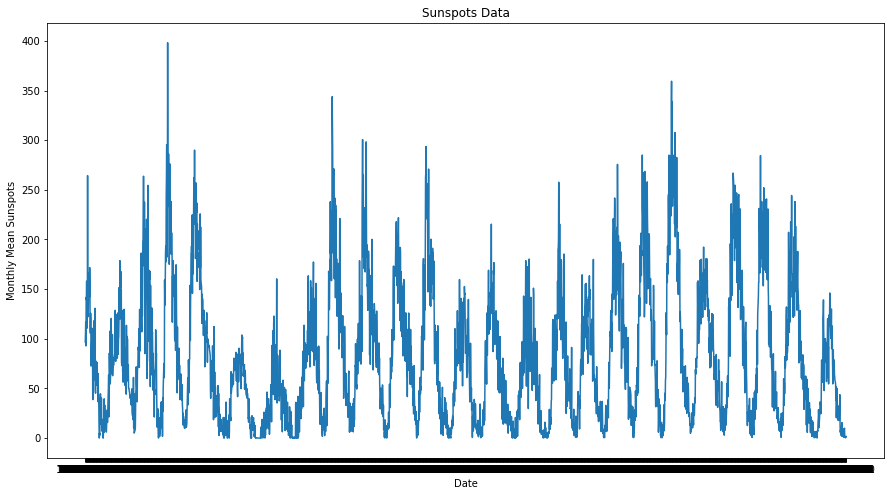

In [6]:
#Plot initial data
series_array = np.array(sunspots)
time_array = np.array(date)
plt.figure(figsize=(15,8))
plt.plot(time_array,series_array)
plt.title('Sunspots Data')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Sunspots')

<h2>3. Stationary Test using ADF<h2/>

In [7]:
t_series = sun_df['Sunspots']
t_series.head(10)

0     96.7
1    104.3
2    116.7
3     92.8
4    141.7
5    139.2
6    158.0
7    110.5
8    126.5
9    125.8
Name: Sunspots, dtype: float64

In [8]:
t_series.describe()

count    3252.000000
mean       82.070695
std        67.864736
min         0.000000
25%        24.200000
50%        67.750000
75%       122.700000
max       398.200000
Name: Sunspots, dtype: float64

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
#Stationary test using Dickey-Fuller test
def stationary_test(time_series):
    #ploting rolling mean & and standard deviation 
    rolling_mean = pd.Series(time_series).rolling(window = 16).mean()
    rolling_stnd = pd.Series(time_series).rolling(window = 16).std()
    original = plt.plot(time_series, color = 'green', label = 'Original')
    mean = plt.plot(rolling_mean, color = 'blue', label = 'Rolling Mean')
    std = plt.plot(rolling_stnd, color = 'red', label = 'Rollind Standard Deviation')
    plt.legend(loc = 'best')
    plt.show()
    #Dickey-Fuller test
    print('Dickey-Fuller test')
    df_test = adfuller(t_series, autolag = 'AIC')
    df_out = pd.Series(df_test[0:4], index = ['ADF test statistics','p-value', 'number of lags used','Number of obeservaations used'])
    for key,value in df_test[4].items():
        df_out['Critical value (%s)' %key] = value
        
    pd.options.display.float_format = '{:.8f}'.format
    print(df_out)   
#I could not find good reference on graphing & ADF so I borrowed this part directly from the class example

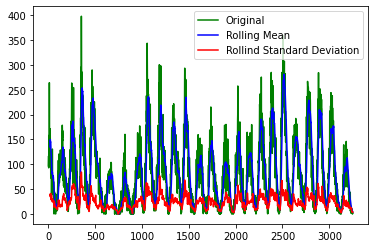

Dickey-Fuller test
ADF test statistics              -10.48086843
p-value                            0.00000000
number of lags used               28.00000000
Number of obeservaations used   3223.00000000
Critical value (1%)               -3.43238057
Critical value (5%)               -2.86243718
Critical value (10%)              -2.56724759
dtype: float64


In [11]:
stationary_test(t_series)

ADF test statistics (-10.48) is significatly smaller than 1% critical value (-3.43) hence time series (t_series) is very likely to be stationary.

<h2>4. Preparing Train and Test Data<h2/>

In [12]:
#reformat data and index
sun_df['Date'] = pd.to_datetime(sun_df['Date'])
sun_df = sun_df.set_index('Date')

In [13]:
#Function for creating data sets with given time_steps
def create_ds(Data, time_steps):
    Xse = []
    yse = []
    for i in range(len(Data) - time_steps):
        Xse.append(Data.iloc[i:(i + time_steps)].values)
        yse.append(Data.iloc[i + time_steps])
    return np.array(Xse), np.array(yse)

In [35]:
#Split data from Aug 2018 -10 months(time step) which is iloc=3225
train_size=3225 
sun_train = sun_df['Sunspots'].iloc[0:train_size]
sun_test = sun_df['Sunspots'].iloc[train_size+1:]
test_time = sun_df.reset_index()['Date'].iloc[train_size+11:]
sun_train.shape

(3225,)

In [37]:
test_time

3236   2018-09-30
3237   2018-10-31
3238   2018-11-30
3239   2018-12-31
3240   2019-01-31
3241   2019-02-28
3242   2019-03-31
3243   2019-04-30
3244   2019-05-31
3245   2019-06-30
3246   2019-07-31
3247   2019-08-31
3248   2019-09-30
3249   2019-10-31
3250   2019-11-30
3251   2019-12-31
Name: Date, dtype: datetime64[ns]

In [16]:
sun_train

Date
1749-01-31    96.70000000
1749-02-28   104.30000000
1749-03-31   116.70000000
1749-04-30    92.80000000
1749-05-31   141.70000000
                 ...     
2017-05-31    18.90000000
2017-06-30    19.20000000
2017-07-31    17.80000000
2017-08-31    32.60000000
2017-09-30    43.70000000
Name: Sunspots, Length: 3225, dtype: float64

In [17]:
X_train, y_train = create_ds(sun_train, time_steps=10)
X_test, y_test = create_ds(sun_test, time_steps=10)

In [18]:
#Reshape Dimensions to match NN model layer0 requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
X_train.shape

(3215, 10, 1)

<h2>5. Create NN Model(1) and Training</h2>
LSTM and Dense layers model with epochs=50, LR=0.01

In [20]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(layers.LSTM(32))
model.add(layers.Dense(16))
model.add(layers.Dense(1))
#specify optimizer and learing rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics = ["mae"]) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=50,batch_size=128,shuffle=False)

Epoch 1/50
26/26 [==============================] - 0s 15ms/step - loss: 7595.3062 - mae: 63.9239
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 2102.5989 - mae: 28.8720
Epoch 3/50
26/26 [==============================] - 0s 15ms/step - loss: 1056.9045 - mae: 23.0505
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 883.2789 - mae: 21.1284
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 815.1791 - mae: 20.6685
Epoch 6/50
26/26 [==============================] - 0s 14ms/step - loss: 722.9995 - mae: 19.3016
Epoch 7/50
26/26 [==============================] - 0s 14ms/step - loss: 778.1807 - mae: 19.7781
Epoch 8/50
26/26 [==============================] - 0s 15ms/step - loss: 822.2176 - mae: 20.4128
Epoch 9/50
26/26 [==============================] - 0s 16ms/step - loss: 960.6880 - mae: 22.0022
Epoch 10/50
26/26 [==============================] - 0s 15ms/step - loss: 779.9240 - mae: 20.0173
Epoch 11/50
26/26 [=======

<h2>6. Create NN Model(2) and Training</h2>
LSTM and Dense layers model with epochs=300, LR=0.01

In [22]:
model2 = tf.keras.models.Sequential()
model2.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(layers.LSTM(32))
model2.add(layers.Dense(16))
model2.add(layers.Dense(1))
#specify optimizer and learing rate
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics = ["mae"]) 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
history2 = model2.fit(X_train, y_train, epochs=300,batch_size=128,shuffle=False)

Epoch 1/300
26/26 [==============================] - 0s 15ms/step - loss: 8175.6143 - mae: 66.3189
Epoch 2/300
26/26 [==============================] - 0s 15ms/step - loss: 2356.5564 - mae: 30.5542
Epoch 3/300
26/26 [==============================] - 0s 15ms/step - loss: 898.5907 - mae: 20.8420
Epoch 4/300
26/26 [==============================] - 0s 14ms/step - loss: 806.9240 - mae: 20.1619
Epoch 5/300
26/26 [==============================] - 0s 15ms/step - loss: 765.3586 - mae: 19.6943
Epoch 6/300
26/26 [==============================] - 0s 16ms/step - loss: 848.6677 - mae: 20.5490
Epoch 7/300
26/26 [==============================] - 0s 16ms/step - loss: 784.3071 - mae: 19.8339
Epoch 8/300
26/26 [==============================] - 0s 15ms/step - loss: 830.2029 - mae: 20.3734
Epoch 9/300
26/26 [==============================] - 0s 14ms/step - loss: 748.8258 - mae: 19.5297
Epoch 10/300
26/26 [==============================] - 0s 16ms/step - loss: 758.1725 - mae: 19.6875
Epoch 11/300
26/2

26/26 [==============================] - 0s 16ms/step - loss: 619.8407 - mae: 17.3641
Epoch 164/300
26/26 [==============================] - 0s 15ms/step - loss: 619.4094 - mae: 17.3612
Epoch 165/300
26/26 [==============================] - 0s 15ms/step - loss: 620.9922 - mae: 17.3709
Epoch 166/300
26/26 [==============================] - 0s 15ms/step - loss: 626.0652 - mae: 17.4508
Epoch 167/300
26/26 [==============================] - 0s 15ms/step - loss: 631.1194 - mae: 17.4889
Epoch 168/300
26/26 [==============================] - 0s 15ms/step - loss: 636.4772 - mae: 17.5545
Epoch 169/300
26/26 [==============================] - 0s 15ms/step - loss: 628.2425 - mae: 17.4410
Epoch 170/300
26/26 [==============================] - 0s 14ms/step - loss: 628.6345 - mae: 17.4867
Epoch 171/300
26/26 [==============================] - 0s 15ms/step - loss: 620.3221 - mae: 17.3433
Epoch 172/300
26/26 [==============================] - 0s 15ms/step - loss: 626.9641 - mae: 17.4091
Epoch 173/300


<h2>7. Create NN Model(3) and Training</h2>
LSTM and Dense layers model with epochs=300, LR=0.001

In [24]:
model3 = tf.keras.models.Sequential()
model3.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model3.add(layers.LSTM(32))
model3.add(layers.Dense(16))
model3.add(layers.Dense(1))
#specify optimizer and learing rate
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics = ["mae"]) 
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [25]:
history3 = model3.fit(X_train, y_train, epochs=300,batch_size=128,shuffle=False)

Epoch 1/300
26/26 [==============================] - 0s 15ms/step - loss: 10949.2129 - mae: 79.8579
Epoch 2/300
26/26 [==============================] - 0s 14ms/step - loss: 9940.9844 - mae: 74.2688
Epoch 3/300
26/26 [==============================] - 0s 15ms/step - loss: 8804.7031 - mae: 68.4969
Epoch 4/300
26/26 [==============================] - 0s 15ms/step - loss: 7806.3882 - mae: 63.8686
Epoch 5/300
26/26 [==============================] - 0s 15ms/step - loss: 6865.1211 - mae: 57.9764
Epoch 6/300
26/26 [==============================] - 0s 15ms/step - loss: 5960.6646 - mae: 52.2503
Epoch 7/300
26/26 [==============================] - 0s 15ms/step - loss: 5134.9893 - mae: 47.2435
Epoch 8/300
26/26 [==============================] - 0s 16ms/step - loss: 4400.3799 - mae: 42.7355
Epoch 9/300
26/26 [==============================] - 0s 15ms/step - loss: 3767.4302 - mae: 38.8137
Epoch 10/300
26/26 [==============================] - 0s 14ms/step - loss: 3235.2495 - mae: 35.4781
Epoch 11

26/26 [==============================] - 0s 16ms/step - loss: 472.8834 - mae: 14.6794
Epoch 165/300
26/26 [==============================] - 0s 15ms/step - loss: 473.6264 - mae: 14.7213
Epoch 166/300
26/26 [==============================] - 0s 14ms/step - loss: 475.4499 - mae: 14.7284
Epoch 167/300
26/26 [==============================] - 0s 15ms/step - loss: 473.3330 - mae: 14.7010
Epoch 168/300
26/26 [==============================] - 0s 14ms/step - loss: 473.9157 - mae: 14.7077
Epoch 169/300
26/26 [==============================] - 0s 15ms/step - loss: 468.4923 - mae: 14.6004
Epoch 170/300
26/26 [==============================] - 0s 15ms/step - loss: 467.0255 - mae: 14.5974
Epoch 171/300
26/26 [==============================] - 0s 16ms/step - loss: 465.7921 - mae: 14.6039
Epoch 172/300
26/26 [==============================] - 0s 15ms/step - loss: 462.8371 - mae: 14.5265
Epoch 173/300
26/26 [==============================] - 0s 15ms/step - loss: 459.9489 - mae: 14.4954
Epoch 174/300


26/26 [==============================] - 0s 16ms/step - loss: 391.6823 - mae: 12.9900
Epoch 247/300
26/26 [==============================] - 0s 15ms/step - loss: 397.6867 - mae: 13.1733
Epoch 248/300
26/26 [==============================] - 0s 14ms/step - loss: 405.4911 - mae: 13.2934
Epoch 249/300
26/26 [==============================] - 0s 14ms/step - loss: 393.2673 - mae: 13.1700
Epoch 250/300
26/26 [==============================] - 0s 14ms/step - loss: 392.0649 - mae: 13.1623
Epoch 251/300
26/26 [==============================] - 0s 14ms/step - loss: 414.1265 - mae: 13.6383
Epoch 252/300
26/26 [==============================] - 0s 14ms/step - loss: 396.2310 - mae: 13.2112
Epoch 253/300
26/26 [==============================] - 0s 14ms/step - loss: 380.2566 - mae: 12.8509
Epoch 254/300
26/26 [==============================] - 0s 16ms/step - loss: 373.8076 - mae: 12.6687
Epoch 255/300
26/26 [==============================] - 0s 15ms/step - loss: 371.0976 - mae: 12.6173
Epoch 256/300


<h2>8. Create NN Model(4) and Training</h2>
SimpleRNN and Dense layers model with epochs=50 LR=0.01

In [26]:
model4 = tf.keras.models.Sequential()
model4.add(layers.SimpleRNN(64, activation="relu",return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model4.add(layers.SimpleRNN(32, activation="relu"))
model4.add(layers.Dense(16))
model4.add(layers.Dense(1))
#specify optimizer and learing rate
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics = ["mae"]) 
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 64)            4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________


In [27]:
history4 = model4.fit(X_train, y_train, epochs=50,batch_size=128,shuffle=False)

Epoch 1/50
26/26 [==============================] - 0s 6ms/step - loss: 4251.8701 - mae: 42.2879
Epoch 2/50
26/26 [==============================] - 0s 6ms/step - loss: 778.9625 - mae: 19.7497
Epoch 3/50
26/26 [==============================] - 0s 6ms/step - loss: 656.6696 - mae: 18.2444
Epoch 4/50
26/26 [==============================] - 0s 6ms/step - loss: 644.1962 - mae: 18.1108
Epoch 5/50
26/26 [==============================] - 0s 6ms/step - loss: 640.1637 - mae: 18.0701
Epoch 6/50
26/26 [==============================] - 0s 6ms/step - loss: 638.1643 - mae: 18.0438
Epoch 7/50
26/26 [==============================] - 0s 6ms/step - loss: 650.6076 - mae: 18.1991
Epoch 8/50
26/26 [==============================] - 0s 6ms/step - loss: 645.7138 - mae: 18.1478
Epoch 9/50
26/26 [==============================] - 0s 6ms/step - loss: 639.9134 - mae: 18.0830
Epoch 10/50
26/26 [==============================] - 0s 6ms/step - loss: 641.3511 - mae: 18.1121
Epoch 11/50
26/26 [===================

<h2>9. Create NN Model(5) and Training</h2>
SimpleRNN and Dense layers model with epochs=300 LR=0.01

In [39]:
model5 = tf.keras.models.Sequential()
model5.add(layers.SimpleRNN(64, activation="relu",return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model5.add(layers.SimpleRNN(32, activation="relu"))
model5.add(layers.Dense(16))
model5.add(layers.Dense(1))
#specify optimizer and learing rate
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics = ["mae"]) 
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 64)            4224      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________


In [40]:
history5 = model5.fit(X_train, y_train, epochs=300,batch_size=128,shuffle=False)

Epoch 1/300
26/26 [==============================] - 0s 6ms/step - loss: 3696.9480 - mae: 37.6911
Epoch 2/300
26/26 [==============================] - 0s 6ms/step - loss: 1010.1918 - mae: 22.0492
Epoch 3/300
26/26 [==============================] - 0s 6ms/step - loss: 752.0170 - mae: 19.3627
Epoch 4/300
26/26 [==============================] - 0s 6ms/step - loss: 655.6533 - mae: 18.1802
Epoch 5/300
26/26 [==============================] - 0s 6ms/step - loss: 647.3399 - mae: 18.1027
Epoch 6/300
26/26 [==============================] - 0s 6ms/step - loss: 643.1660 - mae: 18.0808
Epoch 7/300
26/26 [==============================] - 0s 7ms/step - loss: 642.6288 - mae: 18.1340
Epoch 8/300
26/26 [==============================] - 0s 6ms/step - loss: 639.5953 - mae: 18.0746
Epoch 9/300
26/26 [==============================] - 0s 7ms/step - loss: 670.1177 - mae: 18.3524
Epoch 10/300
26/26 [==============================] - 0s 7ms/step - loss: 841.3094 - mae: 20.4594
Epoch 11/300
26/26 [=======

26/26 [==============================] - 0s 6ms/step - loss: 737.1425 - mae: 19.2781
Epoch 168/300
26/26 [==============================] - 0s 6ms/step - loss: 714.7838 - mae: 19.0596
Epoch 169/300
26/26 [==============================] - 0s 6ms/step - loss: 627.3612 - mae: 17.9040
Epoch 170/300
26/26 [==============================] - 0s 6ms/step - loss: 601.4883 - mae: 17.4743
Epoch 171/300
26/26 [==============================] - 0s 6ms/step - loss: 617.1448 - mae: 17.8134
Epoch 172/300
26/26 [==============================] - 0s 6ms/step - loss: 609.5460 - mae: 17.5827
Epoch 173/300
26/26 [==============================] - 0s 6ms/step - loss: 619.0867 - mae: 17.8369
Epoch 174/300
26/26 [==============================] - 0s 6ms/step - loss: 613.6404 - mae: 17.7317
Epoch 175/300
26/26 [==============================] - 0s 6ms/step - loss: 638.9412 - mae: 18.0297
Epoch 176/300
26/26 [==============================] - 0s 6ms/step - loss: 609.6362 - mae: 17.7084
Epoch 177/300
26/26 [===

<h2>10. Create NN Model(6) and Training</h2>
SimpleRNN and Dense layers model with epochs=300 LR=0.001

In [41]:
model6 = tf.keras.models.Sequential()
model6.add(layers.SimpleRNN(64, activation="relu",return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model6.add(layers.SimpleRNN(32, activation="relu"))
model6.add(layers.Dense(16))
model6.add(layers.Dense(1))
#specify optimizer and learing rate
model6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics = ["mae"]) 
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 10, 64)            4224      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________


In [42]:
history6 = model6.fit(X_train, y_train, epochs=300,batch_size=128,shuffle=False)

Epoch 1/300
26/26 [==============================] - 0s 6ms/step - loss: 3478.7324 - mae: 38.4741
Epoch 2/300
26/26 [==============================] - 0s 6ms/step - loss: 973.8591 - mae: 21.9070
Epoch 3/300
26/26 [==============================] - 0s 6ms/step - loss: 724.3981 - mae: 19.1045
Epoch 4/300
26/26 [==============================] - 0s 6ms/step - loss: 678.9730 - mae: 18.6017
Epoch 5/300
26/26 [==============================] - 0s 6ms/step - loss: 662.1664 - mae: 18.3631
Epoch 6/300
26/26 [==============================] - 0s 6ms/step - loss: 653.0713 - mae: 18.2303
Epoch 7/300
26/26 [==============================] - 0s 6ms/step - loss: 647.4097 - mae: 18.1532
Epoch 8/300
26/26 [==============================] - 0s 6ms/step - loss: 643.7314 - mae: 18.1064
Epoch 9/300
26/26 [==============================] - 0s 6ms/step - loss: 640.3757 - mae: 18.0655
Epoch 10/300
26/26 [==============================] - 0s 6ms/step - loss: 637.7341 - mae: 18.0250
Epoch 11/300
26/26 [========

26/26 [==============================] - 0s 6ms/step - loss: 371.1529 - mae: 13.4741
Epoch 168/300
26/26 [==============================] - 0s 6ms/step - loss: 370.2311 - mae: 13.4309
Epoch 169/300
26/26 [==============================] - 0s 6ms/step - loss: 373.5132 - mae: 13.5252
Epoch 170/300
26/26 [==============================] - 0s 6ms/step - loss: 380.3376 - mae: 13.6649
Epoch 171/300
26/26 [==============================] - 0s 6ms/step - loss: 389.3069 - mae: 13.8048
Epoch 172/300
26/26 [==============================] - 0s 6ms/step - loss: 381.6177 - mae: 13.6427
Epoch 173/300
26/26 [==============================] - 0s 6ms/step - loss: 379.2888 - mae: 13.6710
Epoch 174/300
26/26 [==============================] - 0s 6ms/step - loss: 374.0470 - mae: 13.5537
Epoch 175/300
26/26 [==============================] - 0s 6ms/step - loss: 369.9984 - mae: 13.5614
Epoch 176/300
26/26 [==============================] - 0s 6ms/step - loss: 365.8748 - mae: 13.5231
Epoch 177/300
26/26 [===

<h2>11. Testing Models and Evaluation</h2>

In [28]:
sun_forecast1=model.predict(X_test)
sun_forecast1.squeeze()

array([11.759328 ,  9.376378 ,  8.621603 ,  7.6262817,  6.391341 ,
        7.0720997,  6.5711856,  7.127194 ,  9.885653 , 11.710561 ,
        8.404339 ,  6.2653046,  5.115945 ,  4.475296 ,  4.605638 ,
        4.0200047], dtype=float32)

In [29]:
sun_forecast2=model2.predict(X_test)
sun_forecast2.squeeze()

array([15.790834  , 14.091815  , 12.383528  ,  4.7403007 ,  9.906532  ,
       14.679951  ,  7.267314  ,  2.7593598 ,  9.728567  ,  4.274091  ,
        2.98378   ,  0.65157884,  2.6507397 ,  0.37726378,  1.9937973 ,
        3.4119053 ], dtype=float32)

In [30]:
sun_forecast3=model3.predict(X_test)
sun_forecast3.squeeze()

array([ 4.2273335 ,  9.249404  ,  6.4212646 ,  5.895375  ,  6.811864  ,
        5.6383715 ,  0.14532366, 14.629008  , 12.336188  , 25.48355   ,
        7.3780804 ,  5.472795  ,  2.8787856 ,  3.7253795 ,  4.821827  ,
        3.0831113 ], dtype=float32)

In [31]:
sun_forecast4=model4.predict(X_test)
sun_forecast4.squeeze()

array([ 8.04123  ,  8.311195 ,  7.329356 ,  5.761051 ,  6.3338223,
        8.351657 ,  4.155072 ,  8.146487 ,  9.307546 , 10.061029 ,
        6.9177084,  4.533552 ,  3.0220945,  6.0104084,  7.8124695,
        3.8408844], dtype=float32)

In [43]:
sun_forecast5=model5.predict(X_test)
sun_forecast5.squeeze()

array([10.739643 ,  8.825368 ,  9.062859 ,  9.280664 ,  9.0846195,
        6.8312445, 10.442478 ,  9.874405 ,  7.3188934, 11.644325 ,
       10.30448  ,  4.262807 ,  3.922913 ,  1.2556107,  4.376428 ,
       -1.2813029], dtype=float32)

In [44]:
sun_forecast6=model6.predict(X_test)
sun_forecast6.squeeze()

array([23.27464   ,  9.93785   ,  5.8456182 , -0.28067106,  6.881495  ,
        9.885563  ,  7.9880433 , 10.831318  ,  7.846864  , 23.68201   ,
       15.925979  , 13.312494  ,  1.5622023 ,  0.34697276,  7.06269   ,
        6.213008  ], dtype=float32)

In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("Sunspots")
    plt.grid(True)

In [33]:
time_actual = sun_test.reset_index()['Date'].iloc[10:]
sun_actual = sun_test.reset_index()['Sunspots'].iloc[10:]

Model 1 MSE:  27.147261932908812
Model 1 MAE:  4.498587810993195
Model 2 MSE:  35.202646576703415
Model 2 MAE:  4.107896744459868
Model 3 MSE:  54.233952514594364
Model 3 MAE:  4.9489553268998865
Model 4 MSE:  22.464187836787605
Model 4 MAE:  4.059356832504273


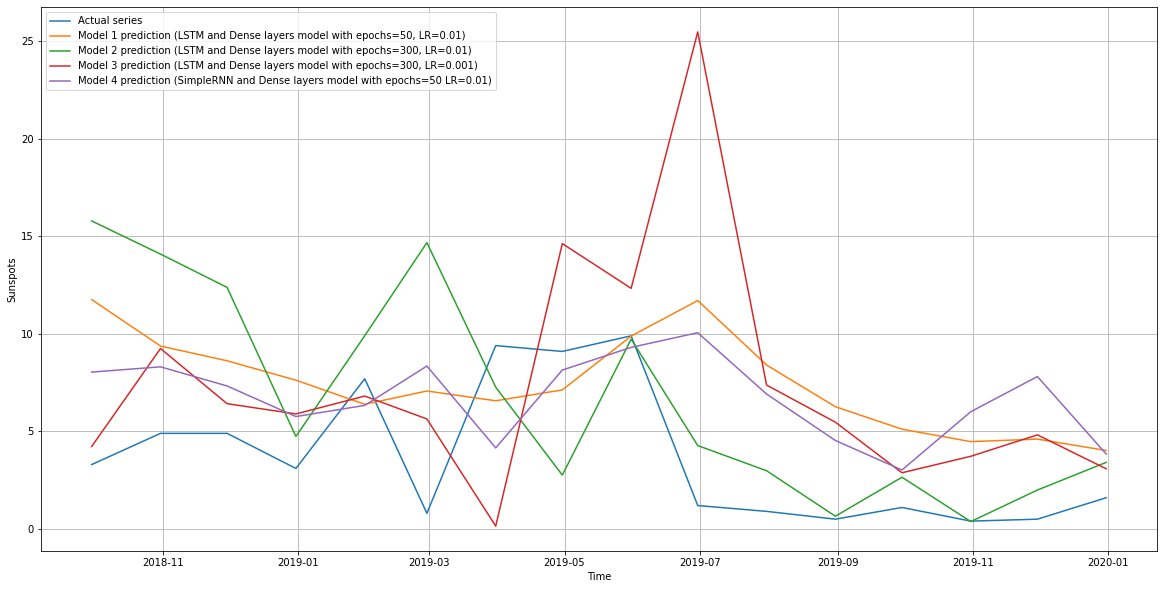

In [38]:
plt.figure(figsize=(20,10))
plot_series(time_actual,sun_actual)
plot_series(test_time,sun_forecast1)
plot_series(test_time,sun_forecast2)
plot_series(test_time,sun_forecast3)
plot_series(test_time,sun_forecast4)
plt.legend(["Actual series",
            "Model 1 prediction (LSTM and Dense layers model with epochs=50, LR=0.01)",
            "Model 2 prediction (LSTM and Dense layers model with epochs=300, LR=0.01)",
            "Model 3 prediction (LSTM and Dense layers model with epochs=300, LR=0.001)",
            "Model 4 prediction (SimpleRNN and Dense layers model with epochs=50 LR=0.01)",])
print("Model 1 MSE: ", mean_squared_error(sun_actual,sun_forecast1))
print("Model 1 MAE: ", mean_absolute_error(sun_actual,sun_forecast1))
print("Model 2 MSE: ", mean_squared_error(sun_actual,sun_forecast2))
print("Model 2 MAE: ", mean_absolute_error(sun_actual,sun_forecast2))
print("Model 3 MSE: ", mean_squared_error(sun_actual,sun_forecast3))
print("Model 3 MAE: ", mean_absolute_error(sun_actual,sun_forecast3))
print("Model 4 MSE: ", mean_squared_error(sun_actual,sun_forecast4))
print("Model 4 MAE: ", mean_absolute_error(sun_actual,sun_forecast4))


Model 4 MSE:  22.464187836787605
Model 4 MAE:  4.059356832504273
Model 5 MSE:  26.04030343756902
Model 5 MAE:  4.223140892386437
Model 6 MSE:  93.06619715898081
Model 6 MAE:  6.653166723251342


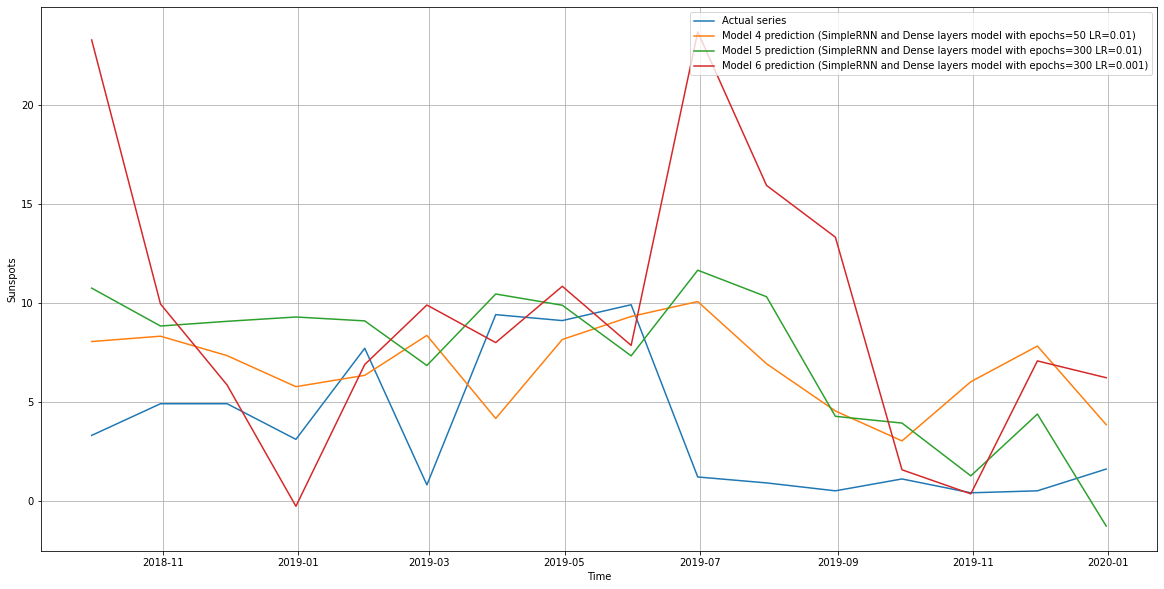

In [45]:
plt.figure(figsize=(20,10))
plot_series(time_actual,sun_actual)
plot_series(test_time,sun_forecast4)
plot_series(test_time,sun_forecast5)
plot_series(test_time,sun_forecast6)
plt.legend(["Actual series",
            "Model 4 prediction (SimpleRNN and Dense layers model with epochs=50 LR=0.01)",
            "Model 5 prediction (SimpleRNN and Dense layers model with epochs=300 LR=0.01)",
            "Model 6 prediction (SimpleRNN and Dense layers model with epochs=300 LR=0.001)",])
print("Model 4 MSE: ", mean_squared_error(sun_actual,sun_forecast4))
print("Model 4 MAE: ", mean_absolute_error(sun_actual,sun_forecast4))
print("Model 5 MSE: ", mean_squared_error(sun_actual,sun_forecast5))
print("Model 5 MAE: ", mean_absolute_error(sun_actual,sun_forecast5))
print("Model 6 MSE: ", mean_squared_error(sun_actual,sun_forecast6))
print("Model 6 MAE: ", mean_absolute_error(sun_actual,sun_forecast6))


Notes:
Surprisingly, simply increasing the epochs from 50 to 300 for models accross the board is not producing good results. My guess is it may be overfitting. With more epochs, the models tends to produce more dramatic predictions. I tried a comparison that has a lower learning rate but it stil didn't fix this issue. And overall simpleRNN is doing better with less epochs (I've tried a few other sets myself with small epochs and they tend to work pretty fine).

In [ ]:
#CS675 project 2 Eric Chen sc54336n@pace.edu